#CafChem tools for using a simple AI Agent to perform chemistry-related tasks using HuggingFace models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/ChemAgent_CafChem.ipynb)

## This notebook allows you to:
- Load a model from HuggingFace
- Create a simple Agent using Langchain.
- View intermediate results of the Agent.
- compare against using the unadorned model.

## Switching between Phi-4-mini-instruct and Apertus-8B-instruct
- Apertus uses '<|assistant_start|>' to start the AI message, where as others use '<|assistant|>' to start the AI message. This should be changed in 3 places

## Requirements:
- This notebook will install several langchain and langgraph libraries and rdkit.
- Runs well on an L4 GPU (using a 7.67 GB model). Will run on the v2-8 TPU runtime, with only slightly slower inference imes. Cannot run on CPU. (Colab runtimes)

## Set-up

### Install libraries

In [1]:
!pip install -U ddgs -q
!pip install --upgrade --quiet  langchain-huggingface
!pip install langchain_core --quiet
! pip -q install langchain_community
!pip install -q langgraph
!pip install -q duckduckgo-search
! pip install rdkit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.8/384.8 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.

### Import libraries and start the model

In [3]:
import torch
from typing import Annotated, TypedDict, Literal
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, trim_messages, AIMessage, HumanMessage, ToolCall

from langchain_huggingface.llms import HuggingFacePipeline
from langchain_huggingface import ChatHuggingFace
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.runnables import chain
from uuid import uuid4
import re
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, QED
from rdkit.Chem import Draw
from rdkit import rdBase
from rdkit.Chem import rdMolAlign
import os
from rdkit import RDConfig
from rdkit.Chem.Features.ShowFeats import _featColors as featColors
from rdkit.Chem.FeatMaps import FeatMaps

fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
hf = HuggingFacePipeline.from_model_id(
    #model_id= "swiss-ai/Apertus-8B-Instruct-2509",
    model_id= "microsoft/Phi-4-mini-instruct",
    task="text-generation",
    pipeline_kwargs = {"max_new_tokens": 500, "temperature": 0.4})

chat_model = ChatHuggingFace(llm=hf)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


## Define Functions

### Chemistry Functions

In [5]:
class State(TypedDict):
  '''
    The state of the agent.
  '''
  messages: Annotated[list, add_messages]
  query_smiles: str
  query_task: str
  query_path: str
  query_reference: str
  tool_choice: Literal["lipinski_tool", "substitution_tool", "pharm_feature_tool"]

def substitution_node(state: State) -> State:
  '''
    A simple substitution routine that looks for a substituent on a phenyl ring and
    substitutes different fragments in that location. Returns a list of novel molecules and their
    QED score (1 is most drug-like, 0 is least drug-like).

      Args:
        smiles: the input smiles string
      Returns:
        new_smiles_string: a string of novel molecules and their QED scores.
  '''
  smiles = state["query_smiles"]

  new_fragments = ["c(Cl)c", "c(F)c", "c(O)c", "c(C)c", "c(OC)c", "c([NH3+])c",
                   "c(Br)c", "c(C(F)(F)(F))c"]

  new_smiles = []
  for fragment in new_fragments:
    m = re.findall(r"c(\D\D*)c", smiles)
    if len(m) != 0:
      for group in m:
        #print(group)
        if fragment not in group:
          new_smile = smiles.replace(group[1:], fragment)
          new_smiles.append(new_smile)

  qeds = []
  for new_smile in new_smiles:
    qeds.append(get_qed(new_smile))

  new_smiles_string = "Novel Molecules or Analogues and QED values: \n"
  for i in range(len(new_smiles)):
    new_smiles_string += f"SMILES: {new_smiles[i]}, QED: {qeds[i]:.3f}\n"

  return {"messages": new_smiles_string}

def get_qed(smiles):
  '''
    Helper function to compute QED for a given molecule.
      Args:
        smiles: the input smiles string
      Returns:
        qed: the QED score of the molecule.
  '''
  mol = Chem.MolFromSmiles(smiles)
  qed = Chem.QED.default(mol)

  return qed

def lipinski_node(state: State) -> State:
  '''
    A tool to calculate QED and other lipinski properties of a molecule.
      Args:
        smiles: the input smiles string
      Returns:
        props_string: a string of the QED and other lipinski properties of the molecule,
                      including Molecular Weight, LogP, HBA, HBD, Polar Surface Area,
                      Rotatable Bonds, Aromatic Rings and Undesireable Moieties.
  '''
  smiles = state["query_smiles"]

  mol = Chem.MolFromSmiles(smiles)
  qed = Chem.QED.default(mol)

  p = Chem.QED.properties(mol)
  mw = p[0]
  logP = p[1]
  hba = p[2]
  hbd = p[3]
  psa = p[4]
  rb = p[5]
  ar = p[6]
  um = p[7]

  props_string = f'''QED and other lipinski properties of the molecule:
    SMILES: {smiles},
    QED: {qed:.3f},
    Molecular Weight: {mw:.3f},
    LogP: {logP:.3f},
    Hydrogen bond acceptors: {hba},
    Hydrogen bond donors: {hbd},
    Polar Surface Area: {psa:.3f},
    Rotatable Bonds: {rb},
    Aromatic Rings: {ar},
    Undesireable moieties: {um}
  '''

  return {"messages": props_string}

def pharmfeature_node(state: State) -> State:
  '''
    A tool to compare the pharmacophore features of a query molecule against
    a those of a reference molecule and report the pharmacophore features of both and the feature
    score of the query molecule.

      Args:
        known_smiles: the reference smiles string
        test_smiles: the query smiles string
      Returns:
        props_string: a string of the pharmacophore features of both molecules and the feature
                      score of the query molecule.
  '''
  test_smiles = state["query_smiles"]
  known_smiles = state["query_reference"]

  smiles = [known_smiles, test_smiles]
  mols = [Chem.MolFromSmiles(x) for x in smiles]

  mols = [Chem.AddHs(m) for m in mols]
  ps = AllChem.ETKDGv3()

  for m in mols:
      AllChem.EmbedMolecule(m,ps)

  o3d = rdMolAlign.GetO3A(mols[1],mols[0])
  o3d.Align()

  keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder', 'Aromatic', 'LumpedHydrophobe')
  feat_hash = {'Donor': 'Hydrogen bond donors', 'Acceptor': 'Hydrogen bond acceptors',
               'NegIonizable': 'Negatively ionizable groups', 'PosIonizable': 'Positively ionizable groups',
               'ZnBinder': 'Zinc Binders', 'Aromatic': 'Aromatic rings', 'LumpedHydrophobe': 'Hydrophobic/non-polar groups' }

  feat_vectors = []
  for m in mols:
      rawFeats = fdef.GetFeaturesForMol(m)
      feat_vectors.append([f for f in rawFeats if f.GetFamily() in keep])

  feat_maps = [FeatMaps.FeatMap(feats = x,weights=[1]*len(x),params=fmParams) for x in feat_vectors]
  test_score = feat_maps[0].ScoreFeats(feat_maps[1].GetFeatures())/(feat_maps[0].GetNumFeatures())

  feats_known = {}
  feats_test = {}
  for feat in feat_vectors[0]:
    if feat.GetFamily() not in feats_known.keys():
      feats_known[feat.GetFamily()]  = 1
    else:
      feats_known[feat.GetFamily()] += 1

  for feat in feat_vectors[1]:
    if feat.GetFamily() not in feats_test.keys():
      feats_test[feat.GetFamily()]  = 1
    else:
      feats_test[feat.GetFamily()] += 1

  props_string = f"The Pharmacophore Feature Overlap Score of the test molecule \
versus the reference molecule is {test_score:.3f}. \n\n"

  for feat in feats_known.keys():
    props_string += f"There are {feats_known[feat]} {feat_hash[feat]} in the reference molecule. \n"

  for feat in feats_test.keys():
    props_string += f"There are {feats_test[feat]} {feat_hash[feat]} in the test molecule. \n"

  return {"messages": props_string}

### Agent-related functions

In [6]:
def first_node(state: State) -> State:
  '''
    The first node of the agent. This node receives the input and asks the LLM
    to determine which is the best tool to use to answer the QUERY TASK.

      Input: the initial prompt from the user. should contain only one of more of the following:

             smiles: the smiles string, task: the query task, path: the path to the file,
             reference: the reference smiles

             the value should be separated from the name by a ':' and each field should
             be separated from the previous one by a ','.

             All of these values are saved to the state

      Output: the tool choice
  '''
  query_smiles = None
  query_task = None
  query_path = None
  query_reference = None
  tool_choice = None

  raw_input = state["messages"][-1].content
  parts = raw_input.split(',')
  for part in parts:
    if 'smiles' in part:
      query_smiles = part.split(':')[1]
      state["query_smiles"] = query_smiles
    if 'task' in part:
      query_task = part.split(':')[1]
      state["query_task"] = query_task
    if 'path' in part:
      query_path = part.split(':')[1]
      state["query_path"] = query_path
    if 'reference' in part:
      query_reference = part.split(':')[1]
      state["query_reference"] = query_reference
  #print(query_smiles, query_task)

  prompt = f'For the QUERY_TASK given below, determine if one of the tools descibed below \
can complete the task. If so, reply with only the tool name followed by "#". \
If the tools cannot complete the task, reply with "None #".\n SMILES: {query_smiles}, \
QUERY_TASK: {query_task}.\n \
Tools: \n \
lipinski_tool: this tool can calculate the following properties: Quantitative \
Estimate of Drug-likeness (QED), Molecular weight, LogP (measures lipophilicity, higher is more lipophilic), \
HBA, HBD, Polar Surface Area, Rotatable Bonds, Aromatic Rings and Undesireable Moieties. \n \
substitution_tool: this tool can generate analogues of the molecule by substituting \
different chemical groups on the original molecule. Returns a list of novel molecules and their \
QED score (1 is most drug-like, 0 is least drug-like). \n \
pharm_feature_tool: this tool can compare the pharmacophore features of a query molecule against \
a those of a reference molecule and report the pharmacophore features of both and the feature \
score of the query molecule. This score tells how the common features score against each other, but \
does not inform about features unique to each molecule.'

  res = chat_model.invoke(prompt)
  #print(res)

  tool_choice = str(res).split('<|assistant|>')[1].split('#')[0].strip()
  state["tool_choice"] = tool_choice

  return state

def parser_node(state: State) -> State:
  '''
    This is the third node in the agent. It receives the output from the tool,
    puts it into a prompt as CONTEXT, and asks the LLM to answer the original
    query.

      Input: the output from the tool.
      Output: the answer to the original query.
  '''
  props_string = state["messages"][-1].content

  query_task = state["query_task"]

  prompt = f'Using the CONTEXT below, answer the original query, which \
was to answer the QUERY_TASK. End your answer with a "#" \
QUERY_TASK: {query_task}.\n \
CONTEXT: {props_string}.\n '

  res = chat_model.invoke(prompt)
  return {"messages": res}

def reflect_node(state: State) -> State:
  '''
    This is the fourth node of the agent. It recieves the LLMs previous answer and
    tries to improve it.

      Input: the LLMs last answer.
      Output: the improved answer.
  '''
  previous_answer = state["messages"][-1].content

  prompt = f'Look at the PREVIOUS ANSWER below which you provided. \
Write an improved answer based on the PREVIOUS ANSWER by adding additional \
clarifying and enriching information. End your new answer with a "#" \
PREVIOUS ANSWER: {previous_answer}.\n '

  res = chat_model.invoke(prompt)
  return {"messages": res}

def get_chemtool(state):
  return state["tool_choice"]

def pretty_print(answer):
  final = str(answer['messages'][-1]).split('<|assistant|>')[-1].split('#')[0].strip("n").strip('\\').strip('n').strip('\\')
  for i in range(0,len(final),100):
    print(final[i:i+100])

def print_short(answer):
  for i in range(0,len(answer),100):
    print(answer[i:i+100])

### Build and compile agent

In [9]:
builder = StateGraph(State)
builder.add_node("first_node", first_node)
builder.add_node("substitution_node", substitution_node)
builder.add_node("lipinski_node", lipinski_node)
builder.add_node("pharmfeature_node", pharmfeature_node)
builder.add_node("parser_node", parser_node)
builder.add_node("reflect_node", reflect_node)

builder.add_edge(START, "first_node")
builder.add_conditional_edges("first_node", get_chemtool, {
    "substitution_tool": "substitution_node",
    "lipinski_tool": "lipinski_node",
    "pharm_feature_tool": "pharmfeature_node"})

builder.add_edge("lipinski_node", "parser_node")
builder.add_edge("substitution_node", "parser_node")
builder.add_edge("pharmfeature_node", "parser_node")

builder.add_edge("parser_node", "reflect_node")
builder.add_edge("reflect_node", END)

graph = builder.compile()

## Use Agent

- the input prompt should contain only one of more of the following:

    ```smiles: the smiles string, task: the query task, path: the path to the file, reference: the reference smiles```

- the value should be separated from the name by a ':' and each field should
  be separated from the previous one by a ','.

### View graph image

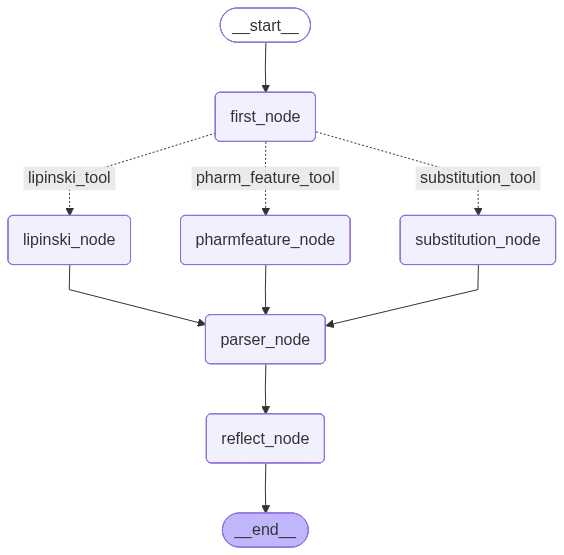

In [10]:
from PIL import Image
import io

img = graph.get_graph().draw_mermaid_png()
image = Image.open(io.BytesIO(img))
image

### Define prompt

In [11]:
input = {
    "messages": [
        HumanMessage('smiles: c1ccc(F)cc1, task: pharmacophore evaluation, reference: O=C(O)[C@@](NN)(Cc1cc(O)c(O)cc1)C')
    ]
}

### Get intermediate output

In [14]:
cs = []
for c in graph.stream(input): #, stream_mode='updates'):
  m = re.findall(r'[a-z]+\_node', str(c))
  if len(m) != 0:
    reply = c[str(m[0])]['messages']
    if 'assistant' in str(reply):
      reply = str(reply).split("<|assistant|>")[-1].split('#')[0].strip()
  print_short(reply)
  cs.append(c)
  print('===================================================')

[HumanMessage(content='smiles: c1ccc(F)cc1, task: pharmacophore evaluation, reference: O=C(O)[C@@](NN)(Cc1cc(O)c(O)cc1)C', additional_kwargs={}, response_metadata={}, id='17c4e0a0-0ac4-4d02-937f-4e03dbab26aa')]
The Pharmacophore Feature Overlap Score of the test molecule versus the reference molecule is 0.250.
 

There are 5 Hydrogen bond donors in the reference molecule. 
There are 4 Hydrogen bond acceptors 
in the reference molecule. 
There are 1 Negatively ionizable groups in the reference molecule. 
Ther
e are 1 Aromatic rings in the reference molecule. 
There are 1 Hydrophobic/non-polar groups in the r
eference molecule. 
There are 1 Hydrogen bond acceptors in the test molecule. 
There are 1 Aromatic 
rings in the test molecule. 
There are 1 Hydrophobic/non-polar groups in the test molecule. 

The pharmacophore evaluation indicates that the test molecule has a partial similarity to the refere
nce molecule with a score of 0.250. The reference molecule contains 5 hydrogen bond donor

### Get only final answer

In [16]:
input = {
    "messages": [
        HumanMessage('smiles: c1ccc(F)cc1, task: obeys lipinskis rules?')
    ]
}

In [17]:
answer = graph.invoke(input)

In [18]:
pretty_print(answer)

The query task asks if the molecule obeys Lipinski\'s rules. Lipinski\'s rules are a set of guidelin
es used to evaluate the druglikeness of a compound, which include criteria such as molecular weight,
 logP, hydrogen bond donors, and hydrogen bond acceptors.\n\nThe given molecule has the following pr
operties:\n- Molecular Weight: 96.104\n- LogP: 1.826\n- Hydrogen bond donors: 0\n- Hydrogen bond acc
eptors: 0\n\nLipinski\'s rules state:\n1. The molecular weight should be less than 500 Daltons.\n2. 
The logP should be less than 5.\n3. The number of hydrogen bond donors should be 0 or 1.\n4. The num
ber of hydrogen bond acceptors should be 0 or 1.\n\nThe given molecule meets all these criteria:\n1.
 Molecular weight is 96.104, which is less than 500.\n2. LogP is 1.826, which is less than 5.\n3. Hy
drogen bond donors are 0, which is 0 or 1.\n4. Hydrogen bond acceptors are 0, which is 0 or 1.\n\nTh
erefore, the molecule obeys Lipinski\'s rules.


In [21]:
input = {
    "messages": [
        HumanMessage('smiles: c1ccc(F)cc1, task: generate analogues')
    ]
}

In [23]:
cs = []
for c in graph.stream(input): #, stream_mode='updates'):
  m = re.findall(r'[a-z]+\_node', str(c))
  if len(m) != 0:
    reply = c[str(m[0])]['messages']
    if 'assistant' in str(reply):
      reply = str(reply).split("<|assistant|>")[-1].split('#')[0].strip()
  print_short(reply)
  cs.append(c)
  print('===================================================')

[HumanMessage(content='smiles: c1ccc(F)cc1, task: substitutions', additional_kwargs={}, response_metadata={}, id='cd21b7f5-9742-450c-a5d2-c089869e0821')]
Novel Molecules or Analogues and QED values: 
SMILES:  c1ccc(Cl)cc1, QED: 0.483
SMILES:  c1ccc(O)cc1
, QED: 0.515
SMILES:  c1ccc(C)cc1, QED: 0.459
SMILES:  c1ccc(OC)cc1, QED: 0.532
SMILES:  c1ccc([NH3+
])cc1, QED: 0.486
SMILES:  c1ccc(Br)cc1, QED: 0.542
SMILES:  c1ccc(C(F)(F)(F))cc1, QED: 0.527

The SMILES string "c1ccc(OC)cc1" has a QED value of 0.532.\n\n
The SMILES string "c1ccc(OC)cc1" corresponds to a compound where an oxygen atom is bonded to a carbo
n atom within a phenyl ring. The QED (Quantitative Estimate of Drug-likeness) value for this molecul
e is 0.532, which indicates a moderate level of drug-likeness according to the QED scoring system. T
his value suggests that the molecule has a reasonable balance between desirable pharmacokinetic prop
erties and potential toxicity, making it a potentially viable candidate for furthe

## Use the model alone without the agentic ability

In [ ]:
chat_model.invoke("does the molecule c1ccc(Br)cc1 obey Lipinski's rules??")

AIMessage(content="<s><|system_start|>You are Apertus, a helpful assistant created by the SwissAI initiative.\nKnowledge cutoff: 2024-04\nCurrent date: 2025-09-06<|system_end|><|developer_start|>Deliberation: disabled\nTool Capabilities: disabled<|developer_end|><|user_start|>does the molecule c1ccc(Br)cc1 obey Lipinski's rules??<|user_end|><|assistant_start|>To determine if the molecule C1CCC(Br)CC1 obeys Lipinski's rules, we need to evaluate it against the four criteria: \n\n1. Molecular Weight (MW) ≤ 500 Da\n2. Number of Hydrogen Bond Donors (HBD) ≤ 5\n3. Number of Hydrogen Bond Acceptors (HBA) ≤ 10\n4. LogP ≤ 5\n\nLet's analyze each criterion:\n\n1. **Molecular Weight (MW)**: The molecular formula for C1CCC(Br)CC1 is C8H12Br, which has a molecular weight of approximately 165.84 g/mol. This is well below the 500 Da threshold.\n\n2. **Number of Hydrogen Bond Donors (HBD)**: The molecule has 8 hydrogen atoms. Each hydrogen atom can act as a hydrogen bond donor, so the maximum number o